## Turning images of equations into LateX: The Pipeline Approach
##### Adam Jensen and Henrik Marklund

### Load packages

In [1]:



# Import keras modules
from keras import optimizers, metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import datetime
import cv2
import math
import pickle

#Import our own functions
import load_data
import helper_functions as hf
import segment_helper_functions as seg_hf
import recursive_profile_cutting as rpc

Using TensorFlow backend.


In [2]:
PYTHON_VERSION = "PYTHON2"



if PYTHON_VERSION == "PYTHON2":
    reload(load_data)
    reload(hf)
    reload(seg_hf)
    reload(rpc)

### Hyperparameters

In [3]:


hparams = {}
hparams['model'] = "BASELINE" #"BASELINE", "CONVNET1", "CONVNET2"
hparams['augmented_data'] = True
hparams['crop_width'] = 30
hparams['crop_height'] = 35
hparams['dsample_factor'] = 0.6

hparams['epochs'] = 20


hparams['load_from_pickle'] = False
hparams['save_to_pickle'] = False # Currently super slow

### Load dataset INFTY-CDB 3 (images of math symbsols)

In [4]:
if hparams['load_from_pickle']:
    data_pickle = pickle.load( open( "data_pickle.p", "rb" ) )
    X = data_pickle['X']
    Y = data_pickle['Y']
    num_unique = data_pickle['num_unique']
    target_token_index = data_pickle['target_token_index']  
else:
    X, Y, num_unique, target_token_index = load_data.load_math_symbols()
    if hparams['save_to_pickle']:
        data_pickle = {'X': X, 'Y': Y, 'num_unique': num_unique, 'target_token_index': target_token_index}
        pickle.dump( data_pickle, open( "data_pickle.p", "wb" ) )
    

('Max width: ', 120)
('Min width: ', 5)
('Mean width: ', 35.558135254894744)
('Max height: ', 188)
('Min heigh: ', 2)
('Mean height: ', 47.714696263997624)
('Number of examples: ', 70637)
Math symbols loaded


In [5]:
reverse_target_token_index = dict(
    (i, token) for token, i in target_token_index.items())

orig_shape = (X.shape[1], X.shape[2])
X, Y = hf.shuffle_data(X,Y, seed=100)

hex_to_token_dict = load_data.get_hex_to_token_dict()

In [7]:
# Down sample images

X_small = hf.down_sample(X, hparams['dsample_factor'])

In [8]:
## Split up to train/val set and test set

Y = np_utils.to_categorical(Y, num_classes = num_unique)

X_train = X_small[:56509]
X_val = X_small[56509:(56509+7063)]
X_test = X_small[(56509+7063):]

Y_train = Y[:56509]
Y_val = Y[56509:(56509+7063)]
Y_test = Y[(56509+7063):]


In [10]:
def augment_data(X,Y, num_k):
    shift = 0.05
    zoom = 0.1
    shear = 0.2
    datagen = ImageDataGenerator(zoom_range=zoom, width_shift_range=shift, height_shift_range=shift)
    #datagen = ImageDataGenerator(zoom_range=zoom)
    
    
    
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1))
    X_augmented = X
    Y_augmented = Y
    
    # fit parameters from data
    datagen.fit(X)
    # Configure batch size and retrieve one batch of images

    counter = 0
    
    for X_batch, y_batch in datagen.flow(X, Y, batch_size=1000):
        # Show 9 images
        
        
        if counter == 0:
            for i in range(0, 9):
                plt.subplot(330 + 1 + i)
                plt.imshow(np.squeeze(X_batch[i]), cmap='gray')
            # show the plot
            plt.show()
        
        X_augmented = np.concatenate((X_augmented, X_batch), axis=0)
        Y_augmented = np.concatenate((Y_augmented, y_batch), axis=0)
        
        counter = counter + 1
        
        if counter % 10 == 0:
            print("Progress: " + str(counter) + "/ " + str(num_k))
        
        if counter == num_k:
            break
    
    return X_augmented, Y_augmented


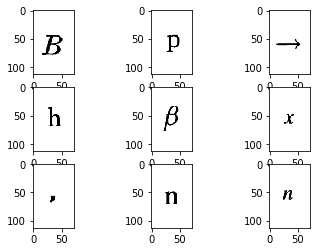

('X_augmented shape: ', (56509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (57509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (58509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (59509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (60509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (61509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (62509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (63509, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (64509, 113, 72, 1))
('X_batch s

('X_augmented shape: ', (126018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (127018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (128018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (129018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (130018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (131018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (132018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (133018, 113, 72, 1))
('X_batch shape: ', (1000, 113, 72, 1))
('Y batch shape: ', (1000, 275))
('X_augmented shape: ', (134018, 113, 72, 1))
('

In [11]:


if hparams['augmented_data']:
    X_train_non_augmented = X_train
    Y_train_non_augmented = Y_train
    
    X_train, Y_train = augment_data(X_train,Y_train, 100)
    
    
X_train, Y_train = hf.shuffle_data(X_train,Y_train, seed=101)

In [4]:
X_train.shape

NameError: name 'X_train' is not defined

In [12]:
X_test = hf.crop_images(X_test, hparams['crop_width'], hparams['crop_height'])
X_val = hf.crop_images(X_val, hparams['crop_width'], hparams['crop_height'])
X_train = hf.crop_images(X_train, hparams['crop_width'], hparams['crop_height'])


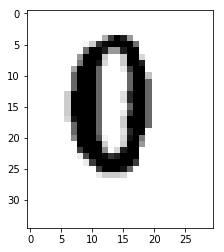

In [33]:
plt.imshow(np.squeeze(X_train[132323]), cmap='gray')
plt.show()



In [34]:
## Normalize and invert
X_test_normalized = hf.normalize_and_invert(X_test)
X_val_normalized = hf.normalize_and_invert(X_val)
X_train_normalized = hf.normalize_and_invert(X_train)

In [35]:
## Reshape images depending on model


if hparams['model'] == "BASELINE":

    X_train_vecs = hf.flatten(X_train_normalized)
    X_val_vecs = hf.flatten(X_val_normalized)
    X_test_vecs = hf.flatten(X_test_normalized)

#If we are using a convnet
else:
    X_train_vecs = hf.add_dimension(X_train_normalized)
    X_val_vecs = hf.add_dimension(X_val_normalized)
    X_test_vecs = hf.add_dimension(X_test_normalized)


In [ ]:
assert Y_train.shape[0] == X_train_vecs.shape[0]

In [36]:
# MODELS adapated from https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/
num_pixels = X_train_vecs.shape[1]
num_classes = Y_test.shape[1]

def baseline_model():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    
    return model

def convnet1(image_size):
    
    height = image_size[0]
    width = image_size[1]
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(height, width, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

def convnet2(image_size):
    
    height = image_size[0]
    width = image_size[1]
    
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(height, width, 1), activation='relu'))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


In [179]:
# build the model

if hparams['model'] == "BASELINE":
    print("Training BASELINE")
    model = baseline_model()
elif hparams['model'] == "CONVNET1":
    print("Training CONVNET1")
    model = convnet1((hparams['crop_height'], hparams['crop_width']))
elif hparams['model'] == "CONVNET2":
    model = convnet2((hparams['crop_height'], hparams['crop_width']))
# Fit the model







Training BASELINE


In [180]:
learning_rate = 0.001 # OBS: Learning rate is set with a callback instead (see next cell)
beta_1 = 0.9 # Keras default
beta_2 = 0.999 # Keras default
epsilon=1e-08 # Keras default
decay=1e-6 # 

adam_optimizer = optimizers.Adam(lr=learning_rate,
                                       beta_1=beta_1,
                                       beta_2=beta_2, 
                                       epsilon=epsilon,
                                       decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [39]:

fit_history = model.fit(X_train_vecs, Y_train, validation_data=(X_val_vecs, Y_val), epochs=hparams['epochs'], batch_size=200, verbose=2)
# Final evaluation of the model

Train on 156018 samples, validate on 7063 samples
Epoch 1/5
 - 38s - loss: 0.8310 - acc: 0.8088 - val_loss: 0.1242 - val_acc: 0.9717
Epoch 2/5
 - 39s - loss: 0.2396 - acc: 0.9347 - val_loss: 0.0938 - val_acc: 0.9778
Epoch 3/5
 - 39s - loss: 0.1500 - acc: 0.9571 - val_loss: 0.0858 - val_acc: 0.9816
Epoch 4/5
 - 39s - loss: 0.1106 - acc: 0.9669 - val_loss: 0.0784 - val_acc: 0.9846
Epoch 5/5
 - 40s - loss: 0.0939 - acc: 0.9721 - val_loss: 0.0644 - val_acc: 0.9864


In [ ]:
scores = model.evaluate(X_test_vecs, Y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
hf.visualize_training_history(fit_history)


In [172]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 26, 30)        780       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 13, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 11, 15)        4065      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 5, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 450)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               57728     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
__________

In [ ]:
# between 80k and 1.5 million parameters

In [ ]:
## SEGMENTING EQUATIONS

In [54]:
## Load Equation dataset

equation_images = load_data.load_equations(40) 

In [ ]:


plt.imshow(equation_images[39], cmap='gray')
plt.show()

In [122]:
def show_segmented_equation(equation_image, smaller_images, show_each_symbol=False):


    backtorgb = np.copy(equation_image)
    plt.imshow(equation_image, cmap='gray')

    for image_with_position in smaller_images:

        plt.show()

        smaller_image = image_with_position['image']
        smaller_image_shape = image_with_position['image'].shape

        corner1y = image_with_position['position'][0]
        corner1x = image_with_position['position'][1]
        corner1 = (corner1x, corner1y)

        corner2y = corner1y + smaller_image_shape[0] - 1
        corner2x = corner1x + smaller_image_shape[1]

        corner2 = (corner2x, corner2y) # x, y

        cv2.rectangle(backtorgb,corner1,corner2,(0,255,0),2)


        if show_each_symbol:
            
            print("Predicted token: ", image_with_position['predicted_token'])
            plt.imshow(smaller_image, cmap='gray')
            plt.show()


    plt.imshow(backtorgb, cmap='gray')
    plt.show()

In [ ]:
#smaller_images[0].shape

#padded_images

In [58]:
#40 35

ta_size = orig_shape






In [119]:
def preprocess_images_for_predict(smaller_images, orig_shape, down_sample_symbol=True):
    padded_images = hf.pad_images(smaller_images, orig_shape)

    if down_sample_symbol:
        down_sampled_images = hf.down_sample(padded_images,hparams['dsample_factor'])

        h = down_sampled_images.shape[1]
        w = down_sampled_images.shape[2]
    else:
        h = padded_images.shape[1]
        w = padded_images.shape[2]

    h_start = int(h / 2 - hparams['crop_height'] / 2)
    w_start = int(w / 2 - hparams['crop_width'] / 2)


    if down_sample_symbol:
        final_images = down_sampled_images[:, h_start:h_start+hparams['crop_height'], w_start:w_start+hparams['crop_width']]
    else:
        final_images = padded_images[:, h_start:h_start+hparams['crop_height'], w_start:w_start+hparams['crop_width']]

    
    return final_images

In [60]:

#image_to_predict = np.reshape(X_train[611], (1, X_train[611].shape[0]*X_train[611].shape[1]))

In [61]:
def last_step_before_predict(final_images):
    images_to_predict = np.reshape(final_images, (final_images.shape[0], final_images.shape[1]*final_images.shape[2]))
    images_to_predict = 255 - images_to_predict
    images_to_predict = images_to_predict.astype('float')
    images_to_predict = images_to_predict / 255.0
    return images_to_predict


In [100]:
def predict_smaller_images(images, orig_shape, down_sample_symbol=True):

    
    images_with_positions = images

    smaller_images = seg_hf.get_just_images(images)
    
    final_images = preprocess_images_for_predict(smaller_images, orig_shape, down_sample_symbol)
    images_to_predict = last_step_before_predict(final_images)
    output = model.predict(images_to_predict)
    tokenids = np.argmax(output, axis=1)
    #print(len(tokenids))
    
    for idx, o in enumerate(tokenids):
        hexa = reverse_target_token_index[o]

        token = hex_to_token_dict[hexa]
        #real_output.append([token, o])
        images[idx]['predicted_token_id'] = o

        images[idx]['id'] = idx
        images[idx]['predicted_token'] = token
        
    return images

In [101]:
# Learned this from: https://stackoverflow.com/questions/8242832/python-all-possible-pairs-of-2-list-elements-and-getting-the-index-of-that-pair
import itertools
def all_pairs(lst):
    for p in itertools.combinations(lst,2):
        i = iter(p)
        yield zip(i,i)

In [102]:
def check_if_equal_sign(image_1,image_2):
    predicted1 = image_1['predicted_token']
    predicted2 = image_2['predicted_token']
    
    if predicted1 != 'minus' or predicted2 != 'minus':
        return False
    
    
    w1 = image_1['image'].shape[1]
    w2 = image_2['image'].shape[1]
    
    cx1 = seg_hf.get_center_from_image(image_1)[1]
    cx2 = seg_hf.get_center_from_image(image_2)[1]
    
    
    
    if np.abs(w1-w2) > 4:
        return False
    if np.abs(cx1 - cx2) > 4:
        return False
    
    return True

In [129]:
def check_if_lc_i(image_1,image_2):
    predicted1 = image_1['predicted_token']
    predicted2 = image_2['predicted_token']
    
    top_symbols = ['comma', 'prime', 'ast']
    bottom_symbols = ['one', 'l', 'i', 'iota']
    
    w1 = image_1['image'].shape[1]
    w2 = image_2['image'].shape[1]
    
    cx1 = seg_hf.get_center_from_image(image_1)[1]
    cx2 = seg_hf.get_center_from_image(image_2)[1]
    
    if np.abs(w1-w2) > 15:
        return False
    if np.abs(cx1 - cx2) > 15:
        return False
    
    
    if is_on_top(image_1, image_2):
        if (predicted1 in top_symbols and predicted2 in bottom_symbols):
            return True
    elif is_on_top(image_2, image_1):
        if (predicted1 in bottom_symbols and predicted2 in top_symbols):
            return True
    
    
    
    return False


In [104]:
## Works

def is_on_top(image_1, image_2):
    centery1, centerx1 = seg_hf.get_center_from_image(image_1)
    centery2, centerx2 = seg_hf.get_center_from_image(image_2)
    
    if centery1 < centery2:
        
        return True
    elif centery1 >= centery2:
        return False
    

In [105]:
def concat_images(image_1, image_2):
    
    if is_on_top(image_1, image_2):
        print("Is on top")
        new_y1 = image_1['position'][0]
        new_x1 = min(image_1['position'][1],image_2['position'][1])
        
        yoffset = image_2['position'][0] - image_1['position'][0] - image_1['image'].shape[0]
        
        image_2_height = image_2['image'].shape[0]
        image_2_width = image_2['image'].shape[1]
        
        image_1_height = image_1['image'].shape[0]
        image_1_width = image_1['image'].shape[1]
        
        new_height = image_1_height + image_2_height + yoffset
        new_width = max(image_1_width, image_2_width)
        
        new_image = 255 * np.ones((new_height, new_width))
        
        new_image[:image_1_height, :image_1_width] = image_1['image']
        new_image[image_1_height+yoffset:, :image_2_width] = image_2['image']
    else:
        new_y1 = image_2['position'][0]
        new_x1 = min(image_1['position'][1],image_2['position'][1])

        yoffset = image_1['position'][0] - image_2['position'][0] - image_2['image'].shape[0]
        image_2_height = image_2['image'].shape[0]
        image_2_width = image_2['image'].shape[1]
        
        image_1_height = image_1['image'].shape[0]
        image_1_width = image_1['image'].shape[1]
        
        new_height = image_1_height + image_2_height + yoffset
        new_width = max(image_1_width, image_2_width)
        
        new_image = 255 * np.ones((new_height, new_width))

        
        new_image[:image_2_height, :image_2_width] = image_2['image']
        print("new_height: ", new_height)
        print("yoffset: ", yoffset)
        print("image_1 shape", image_1['image'].shape)
        new_image[image_2_height+yoffset:, :image_1_width] = image_1['image']
    
    
    new_image_with_position = {}
    new_image_with_position['image'] = new_image
    new_image_with_position['position'] = (new_y1, new_x1)
    
    
    return new_image_with_position

In [108]:


def find_lc_is(images):
    ids_to_remove = []
    
    new_predicted_images = []
    new_list = all_pairs(images)
    
    lower_case_is = []
    
    for pair in new_list:
        
        if PYTHON_VERSION == "PYTHON3":
            pair = list(pair)
        
        image_1 = pair[0][0]
        image_2 = pair[0][1]
        #print(image_1['id'])
        #print(image_2['id'])
        if check_if_lc_i(image_1,image_2):
            new_image = concat_images(image_1, image_2)
            #print("found one equal sign")
            ids_to_remove.append(image_1['id'])
            ids_to_remove.append(image_2['id'])

            new_image['id'] = image_1['id']
            new_image['predicted_token'] = 'i'
            lower_case_is.append(new_image)
    
    
    
    for image in images:
        if image['id'] not in ids_to_remove:
            new_predicted_images.append(image)
    
    for lower_case_i in lower_case_is:
        new_predicted_images.append(lower_case_i)
    
    return new_predicted_images

In [109]:
def find_equal_signs(images):
    ids_to_remove = []
    
    new_predicted_images = []
    
    equal_signs = []
    new_list = all_pairs(images)
    for pair in new_list:
        
        if PYTHON_VERSION == "PYTHON3":
            pair = list(pair)
            
        image_1 = pair[0][0]
        image_2 = pair[0][1]

        if check_if_equal_sign(image_1,image_2):
            new_image = concat_images(image_1, image_2)
            #print("found one equal sign")
            ids_to_remove.append(image_1['id'])
            ids_to_remove.append(image_2['id'])

            
            new_image['id'] = image_1['id']
            new_image['predicted_token'] = 'equal'
            equal_signs.append(new_image)
    
    
    
    for image in images:
        if image['id'] not in ids_to_remove:
            new_predicted_images.append(image)
    
    for equal_sign in equal_signs:
        new_predicted_images.append(equal_sign)
    
    return new_predicted_images

In [110]:
def apply_rules(predicted_images):
    images_processed = find_equal_signs(predicted_images)
    images_processed = find_lc_is(images_processed)
    
    return images_processed

In [111]:
#new_list = all_pairs(predicted_images)



In [112]:
def get_image_area(image_with_position):
    image_shape = image_with_position['image'].shape
    return image_shape[0] * image_shape[1]

In [113]:

def segment_and_apply_rules(equation_image, orig_shape):


    img_with_positions = rpc.segment_equation(equation_image)
    show_segmented_equation(equation_image, img_with_positions)

    predicted_images = predict_smaller_images(img_with_positions, orig_shape)
    rules_applied = apply_rules(predicted_images)

    show_segmented_equation(equation_image, rules_applied)


In [114]:
def get_relative_position(image_1, image_2, properties):
    image1_shape = image_1['image'].shape
    image2_shape = image_2['image'].shape
    
    if len(properties) > 0:
        last_property = properties[-1]
    else:
        last_property = (None, None)
    
    image1_h = image1_shape[0]
    image2_h = image2_shape[0]
    
    positiony1 = image_1['position'][0]
    positionx1 = image_1['position'][1]
    
    positiony2 = image_2['position'][0]
    positionx2 = image_2['position'][1]
    
    centery1, centerx1 = seg_hf.get_center_from_image(image_1)
    centery2, centerx2 = seg_hf.get_center_from_image(image_2) 
    
    # Below, above, sup or sub
    
    if last_property[0] == "SUBRIGHT":
        if positiony2 < last_property[1] + 3:
            properties.pop()
            return ("PREVIOUS", properties)
        
    if last_property[0] == "SUPRIGHT":
        if positiony2 + image2_h > last_property[1] - 3:
            properties.pop()
            return ("PREVIOUS", properties)
    
    if image2_h < image1_h:
        ## Below
        if (centerx2 > positionx1) and centerx2 < positionx1+image1_shape[1] and positiony2 > positiony1 + image1_shape[0]:
            return ("BELOW", properties)

        ## Above
        if centerx2 > positionx1 and centerx2 < positionx1+image1_shape[1] and positiony2 + image2_shape[0] < positiony1:
            return ("ABOVE", properties)


        ## Subscript right
        if centerx1 < positionx2 and positiony2 > centery1:
            properties.append(("SUBRIGHT", centery1))
            return ("SUBRIGHT", properties)

        ## Superscript right
        if centerx1 < positionx2 and positiony2+image2_shape[0] < centery1:
            properties.append(("SUPRIGHT", centery1))
            return ("SUPRIGHT", properties)
        
    ## To the right
    return ("RIGHT", properties)

In [115]:
#for imgg in rules_applied:
    #plt.imshow(imgg['image'])
    #plt.show()


In [134]:
def sort_images(images):
    newlist = sorted(images, key=lambda k: k['id']) 
    return newlist

def structural_analysis_and_latex(images):

    images = sort_images(images)

    latex_string = ""
    prop = []
    for idx in range(len(images)):
        if idx == len(images) - 1:
            latex = seg_hf.get_latex(images[idx]['predicted_token'])
            latex_string += " " + latex
            if len(prop) != 0:
                latex_string += " }"
            break


        rel_pos, props = get_relative_position(images[idx], images[idx+1], prop)
        prop = props


        latex = seg_hf.get_latex(images[idx]['predicted_token'])

        latex_string += " " + latex
        if rel_pos == "SUBRIGHT":
            latex_string += "_{"
        elif rel_pos == "PREVIOUS":
            latex_string += " }"
        elif rel_pos =="SUPRIGHT":
            latex_string += "^{"
        #print(rel_pos)
    
    return latex_string


In [117]:
def image_to_latex(equation_image, show_segmentation=False, show_each_symbol=False, down_sample_symbol=True):
    img_with_positions = rpc.segment_equation(equation_image)
    predicted_images = predict_smaller_images(img_with_positions, orig_shape, down_sample_symbol)
    rules_applied = apply_rules(predicted_images)
    if show_segmentation:
        ims= sort_images(rules_applied)
        show_segmented_equation(equation_image, ims, show_each_symbol=show_each_symbol)
    return structural_analysis_and_latex(rules_applied)

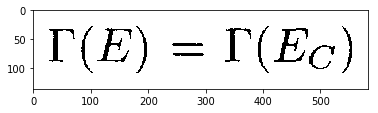

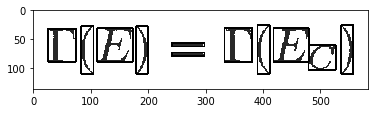

 \succeq \otimes < >^{ \preceq } \preceq \succeq \otimes < z X


In [188]:
print(image_to_latex(equation_image, show_segmentation=True, show_each_symbol=False))

In [ ]:





    
print(latex_string)

In [ ]:
for img in rules_applied:
    plt.imshow(img['image'], cmap='gray')
    plt.show()

In [ ]:
rules_applied

pairs_of_images = all_pairs(rules_applied)

# edge (id1, id2, )


    